# **Customer Segmentation of Good Seed Retail Supermarket**

# Project Goals

Good Seed a supermarket chain wanted to see if Data Science could help them to comply with the law by ensuring that they weren't selling age-restricted products to underage customers. We also asked to carry out an evaluation. Therefore, when we start to work, remember the following:

- Stores from this franchise are equipped with a camera in the cashier area that will display a signal when someone buys a product with an age limit
- Computer vision methods can be used to determine a person's age from a photograph
- Our task is to build and evaluate a model to verify a person's age

To begin the task, we have a set of people photos along with their ages.

# Project Instructions

The following is the project implementation plan:

1. Perform an exploratory data analysis to understand the overview of the dataset.
2. Train and evaluate the model (this process needs to be completed on the GPU platform).
3. Merge your code, both for the output and findings (from the previous points) in the final Jupyter Notebook file.
4. Make a conclusion from the model evaluation, then add the conclusion to the notebook.

## Initialization

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# the next line provides better quality graphics on HiDPI screens

plt.style.use('default')

## 1. Data Preparations

The *dataset* you need is stored in the `/datasets/faces/` folder. In that folder, you can find:
- `final_files` folder with 7.6k photos
- *File* `labels.csv` which contains labels, with two columns: `file_name` and `real_age`

Given the large number of *image* files, it is recommended that you do not read them all at once, as this will only use up computing resources. We recommend you to create a generator with ImageDataGenerator.

The label *file* can be loaded as a normal CSV *file*.

In [ ]:
data_root_path = '/datasets/faces/'

In [ ]:
labels = pd.read_csv(data_root_path + 'labels.csv')

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.sample(5)

file_name  real_age
6408  006412.jpg        58
4991  004991.jpg        18
4328  004328.jpg         6
322   000322.jpg        65
51    000051.jpg        23

In [ ]:
labels.describe(percentiles=[.1, .05, .25, .75, .95, .99]).round(1).T

count  mean   std  min   5%   10%   25%   50%   75%   95%   99%  \
real_age  7591.0  31.2  17.1  1.0  5.0  12.0  20.0  29.0  41.0  63.0  82.0   

            max  
real_age  100.0

**Conclusion**

- There is no missing value or abnormal data in the `real_age` column. It does not require any correction
- The dataset is not too big for the Neural Network model, it may require a data augmentation step or freezing layer

## 2. Exploratory Data Analysis

We already know the `real_age` column is a feature with a value does not exceed 100, so we can calculate its exact value to see its distribution.

In [ ]:
def create_gen_flow(min_age=0, max_age=100):

    datagen = ImageDataGenerator(rescale=1./255)

    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels.query('real_age >= @min_age and real_age <= @max_age'),
        directory=data_root_path + 'final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        seed=12345)

    return gen_flow

In [ ]:
# Count the missing value from the `age` column and fill it with 0

dft1 = labels['real_age'].value_counts().sort_index().reindex(np.arange(0, 101)).fillna(0).astype('int')
dft1


0        0
1      149
2       88
3       25
4      101
      ... 
96       2
97       1
98       0
99       0
100      1
Name: real_age, Length: 101, dtype: int64

In [ ]:
# Grouped the numbers using range 0-4, 5-9, etc

dft2 = pd.cut(labels['real_age'], np.arange(0, 101, 5), right=False).value_counts().sort_index()
dft2


[0, 5)        363
[5, 10)       300
[10, 15)      356
[15, 20)      857
[20, 25)      924
[25, 30)     1151
[30, 35)      920
[35, 40)      644
[40, 45)      545
[45, 50)      395
[50, 55)      391
[55, 60)      224
[60, 65)      174
[65, 70)      105
[70, 75)       89
[75, 80)       41
[80, 85)       50
[85, 90)       28
[90, 95)       28
[95, 100)       5
Name: real_age, dtype: int64

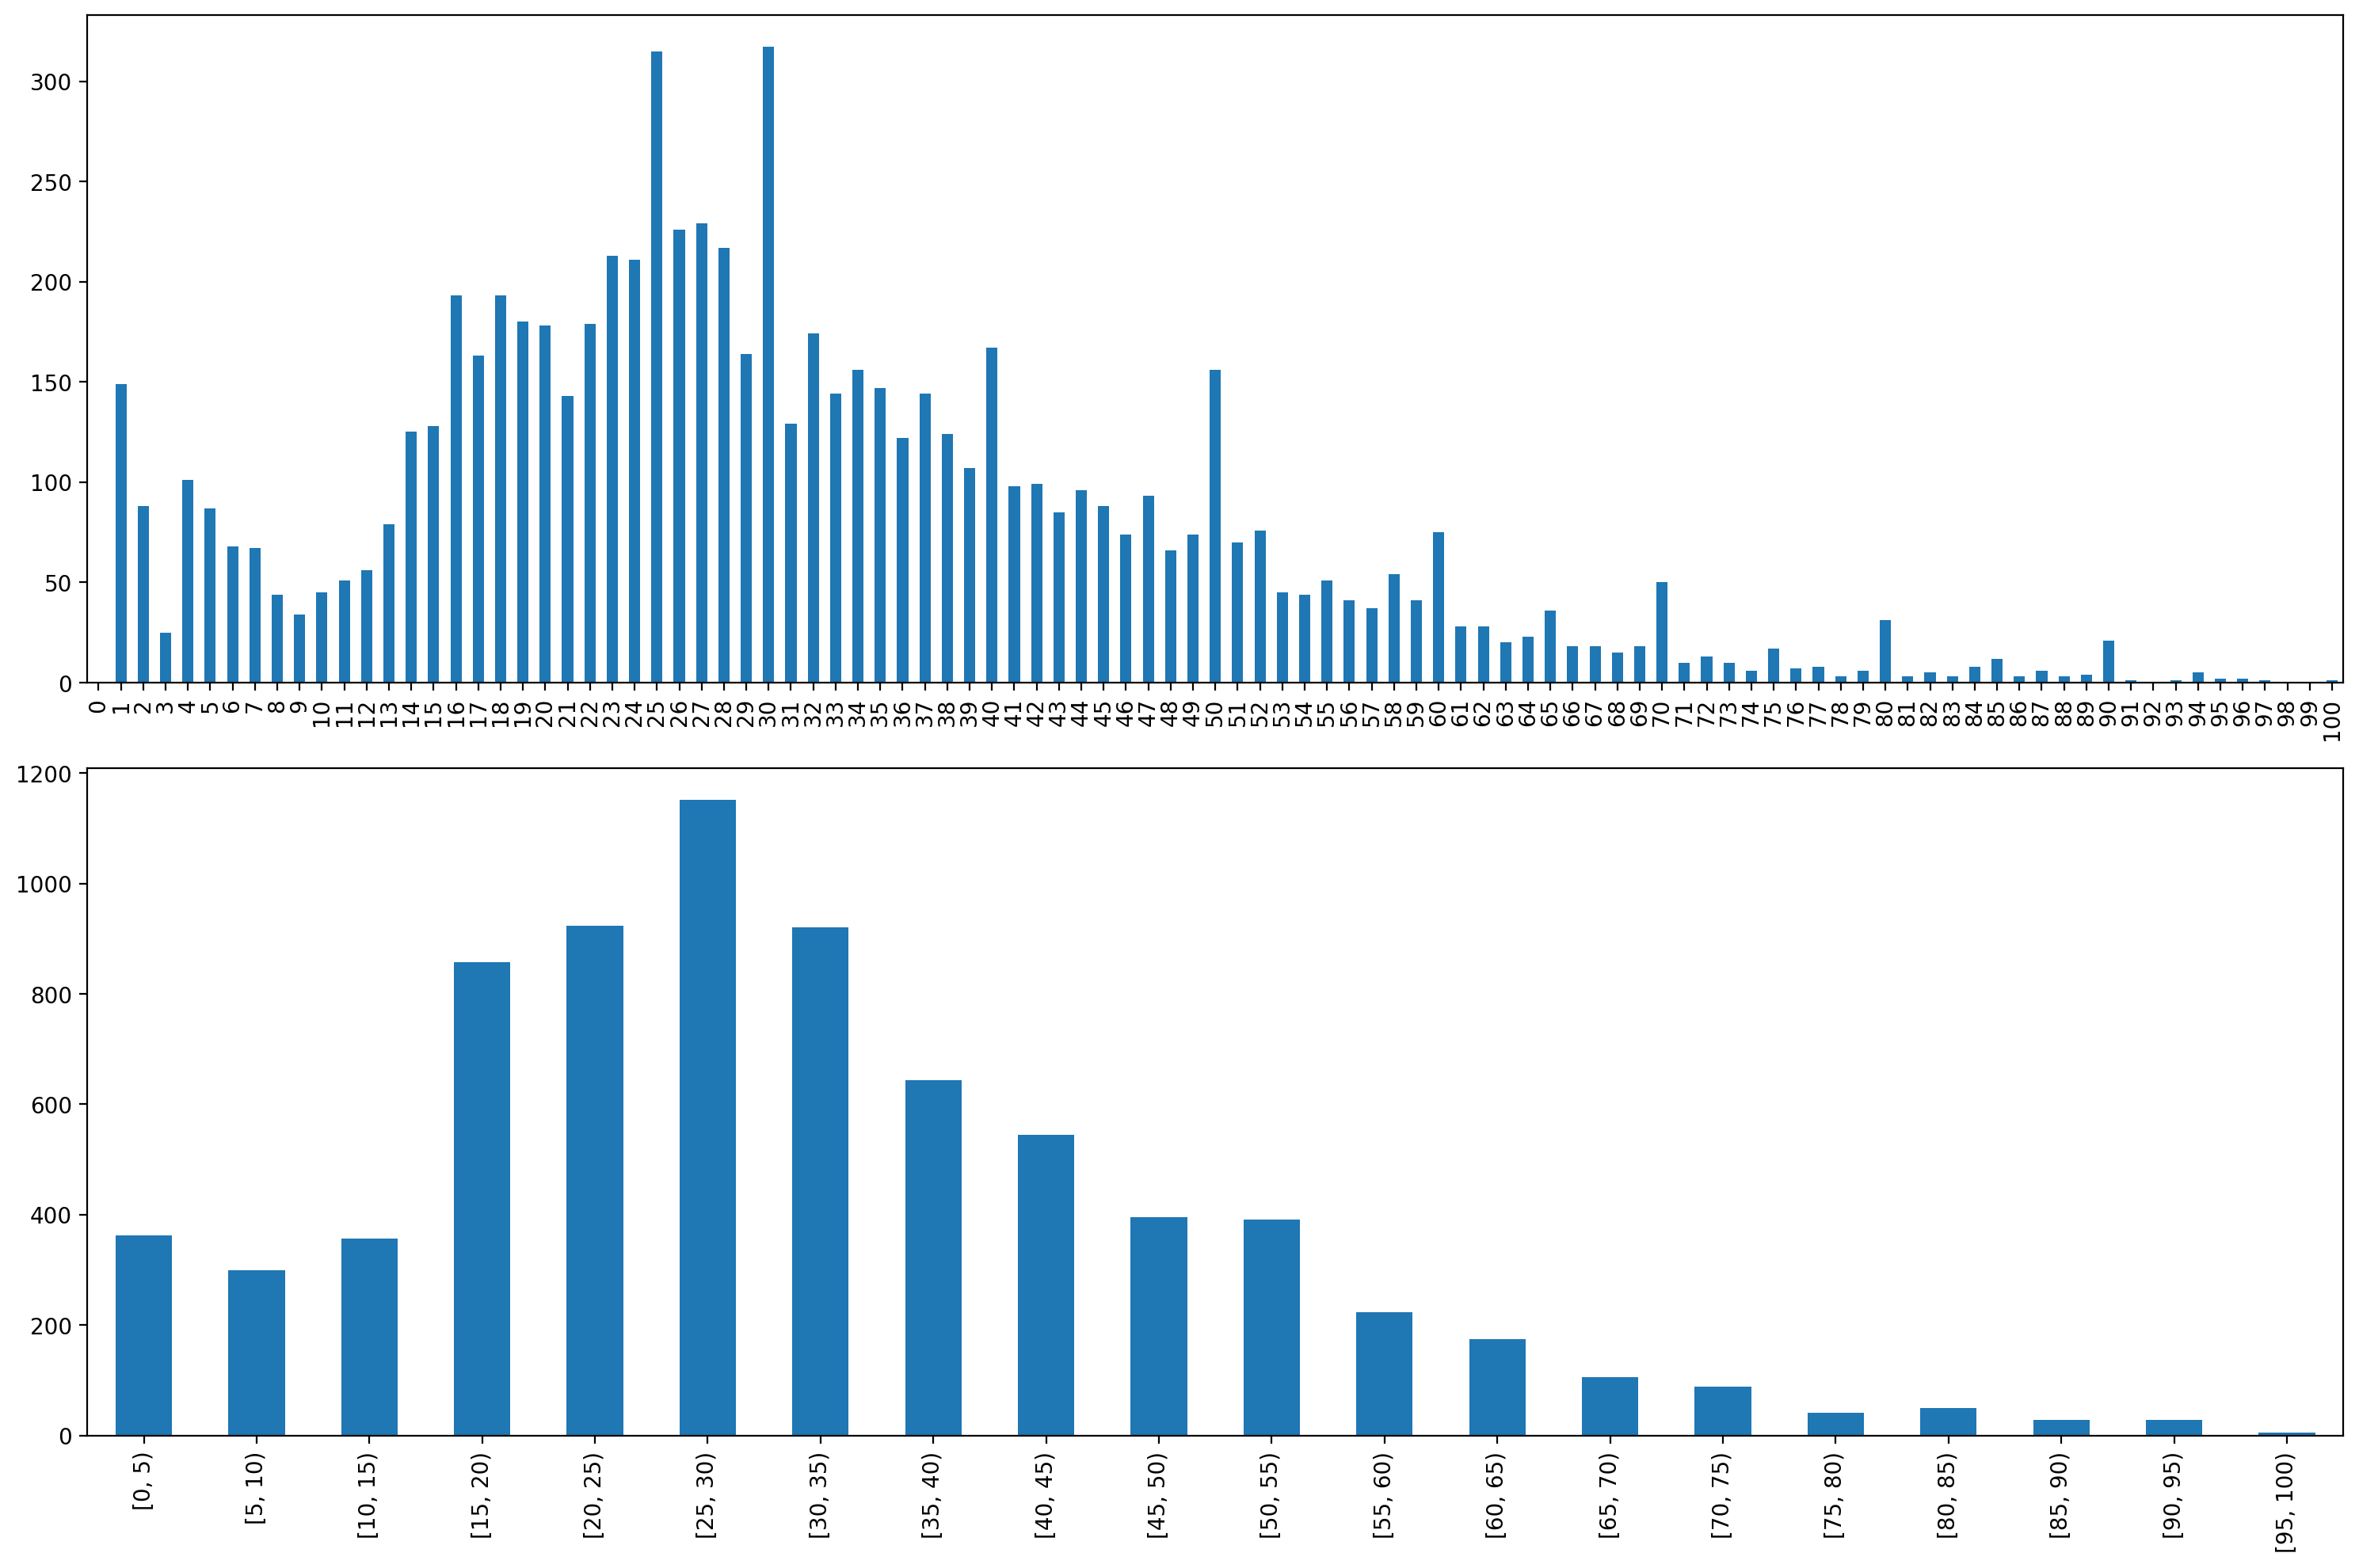

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

ax = axs[0]
dft1.plot(kind='bar', ax=ax)

ax = axs[1]
dft2.plot(kind='bar', ax=ax)

fig.tight_layout()

**Conclusion**

1. There are only a few elderly people in the sample above. This may be because the model has not been properly trained for the elderly category. At the same time, the number of errors that occur may be significant. It's hard to say if we compare between the ages of 80 to 90 years and the ages of 0 to 10 years.
2. There are some people with very old age. Will it be considered as outliers?. Maybe this is because some people's real ages cannot be known, and fill them with specific values. So, do not get confused when training the model, we will drop this data.
3. There are 2 - 4 clusters on the histogram. This may happened because the data obtained from many sources, for example; there is one source that only records children under 10 years old, and another source records people over 10 years of age. Maybe, because there are several images taken from different sources, because it requires different preprocessing techniques.
4. We should try to check some images randomly to narrow down some of the findings above.

In [ ]:
def show_batch(batch, predictions=None):

    rows = 3
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=(10, 6))

    for i in range(15):

        row = i // cols
        col = i % cols
        ax = axs[row][col]
        ax.imshow(batch[0][i])
        real_age = batch[1][i]
        if predictions is None:
            title = f'age: {real_age}'
        else:
            title = f'age: {real_age}, pred: {round(predictions[i])}'
        ax.set_title(title, fontsize='medium')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    fig.tight_layout()

In [ ]:
gen_flow_0_9 = create_gen_flow(min_age=0, max_age=9)
gen_flow_10_79 = create_gen_flow(min_age=10, max_age=79)
gen_flow_80_100 = create_gen_flow(min_age=80, max_age=100)

Found 663 validated image filenames.
Found 6816 validated image filenames.
Found 112 validated image filenames.


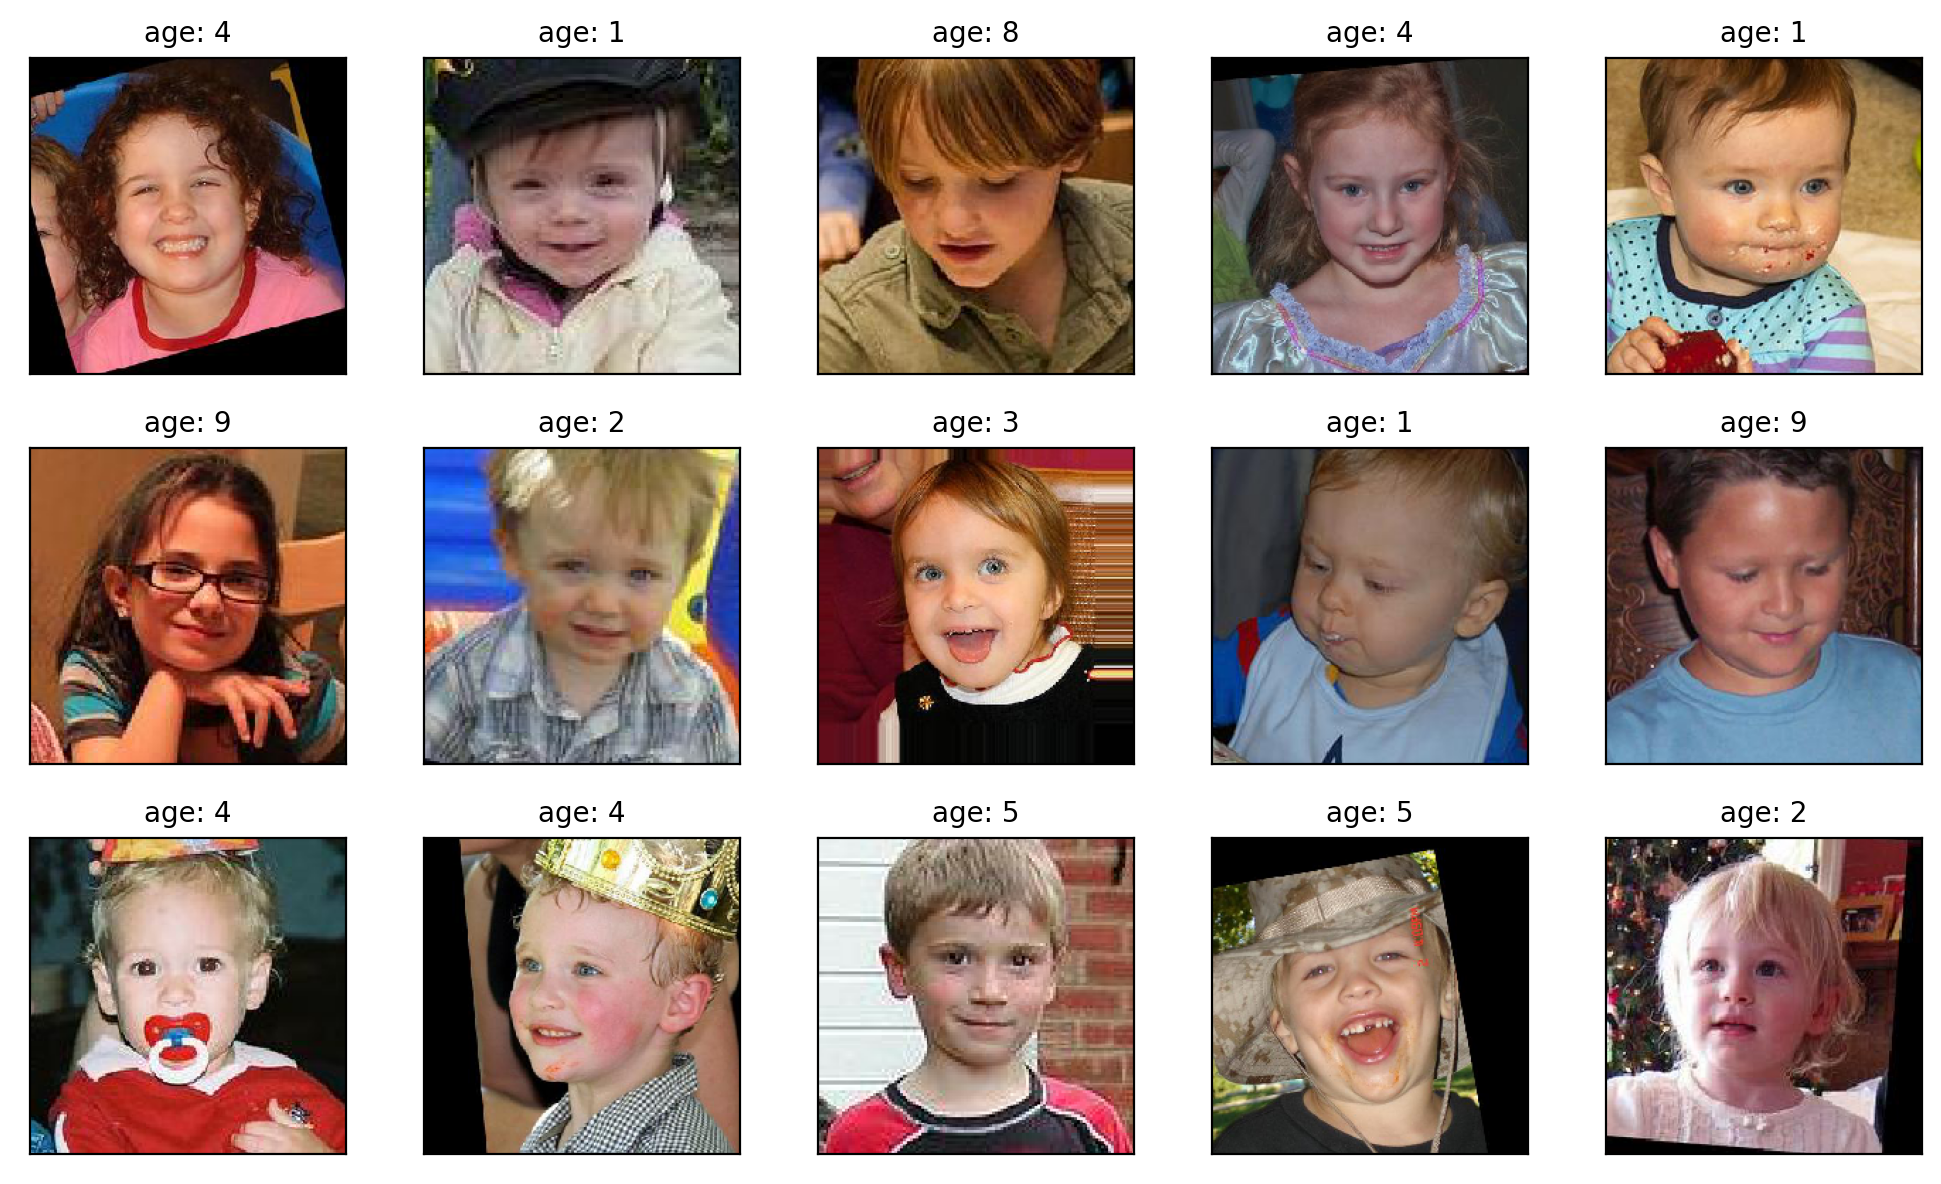

In [ ]:
show_batch(next(gen_flow_0_9))

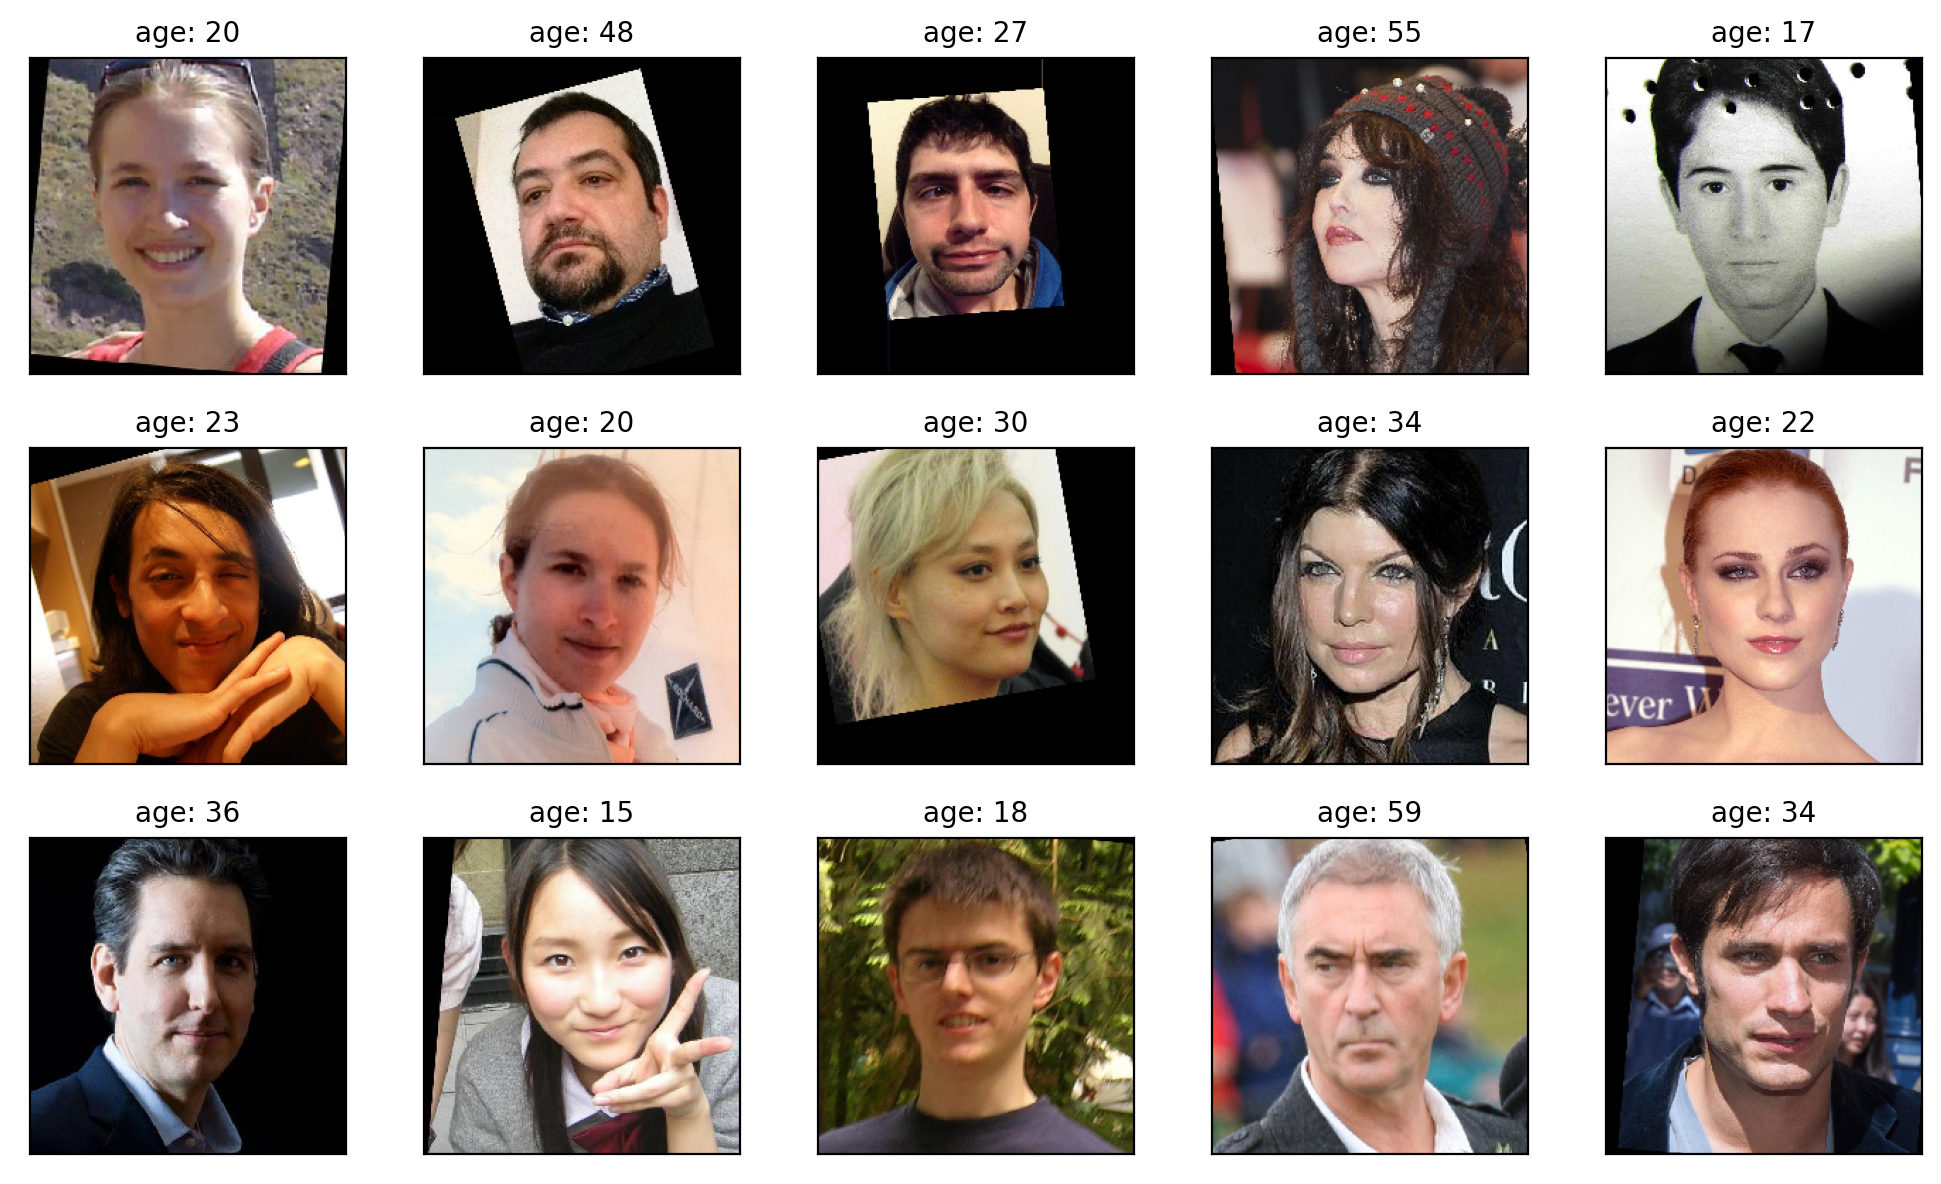

In [ ]:
show_batch(next(gen_flow_10_79))

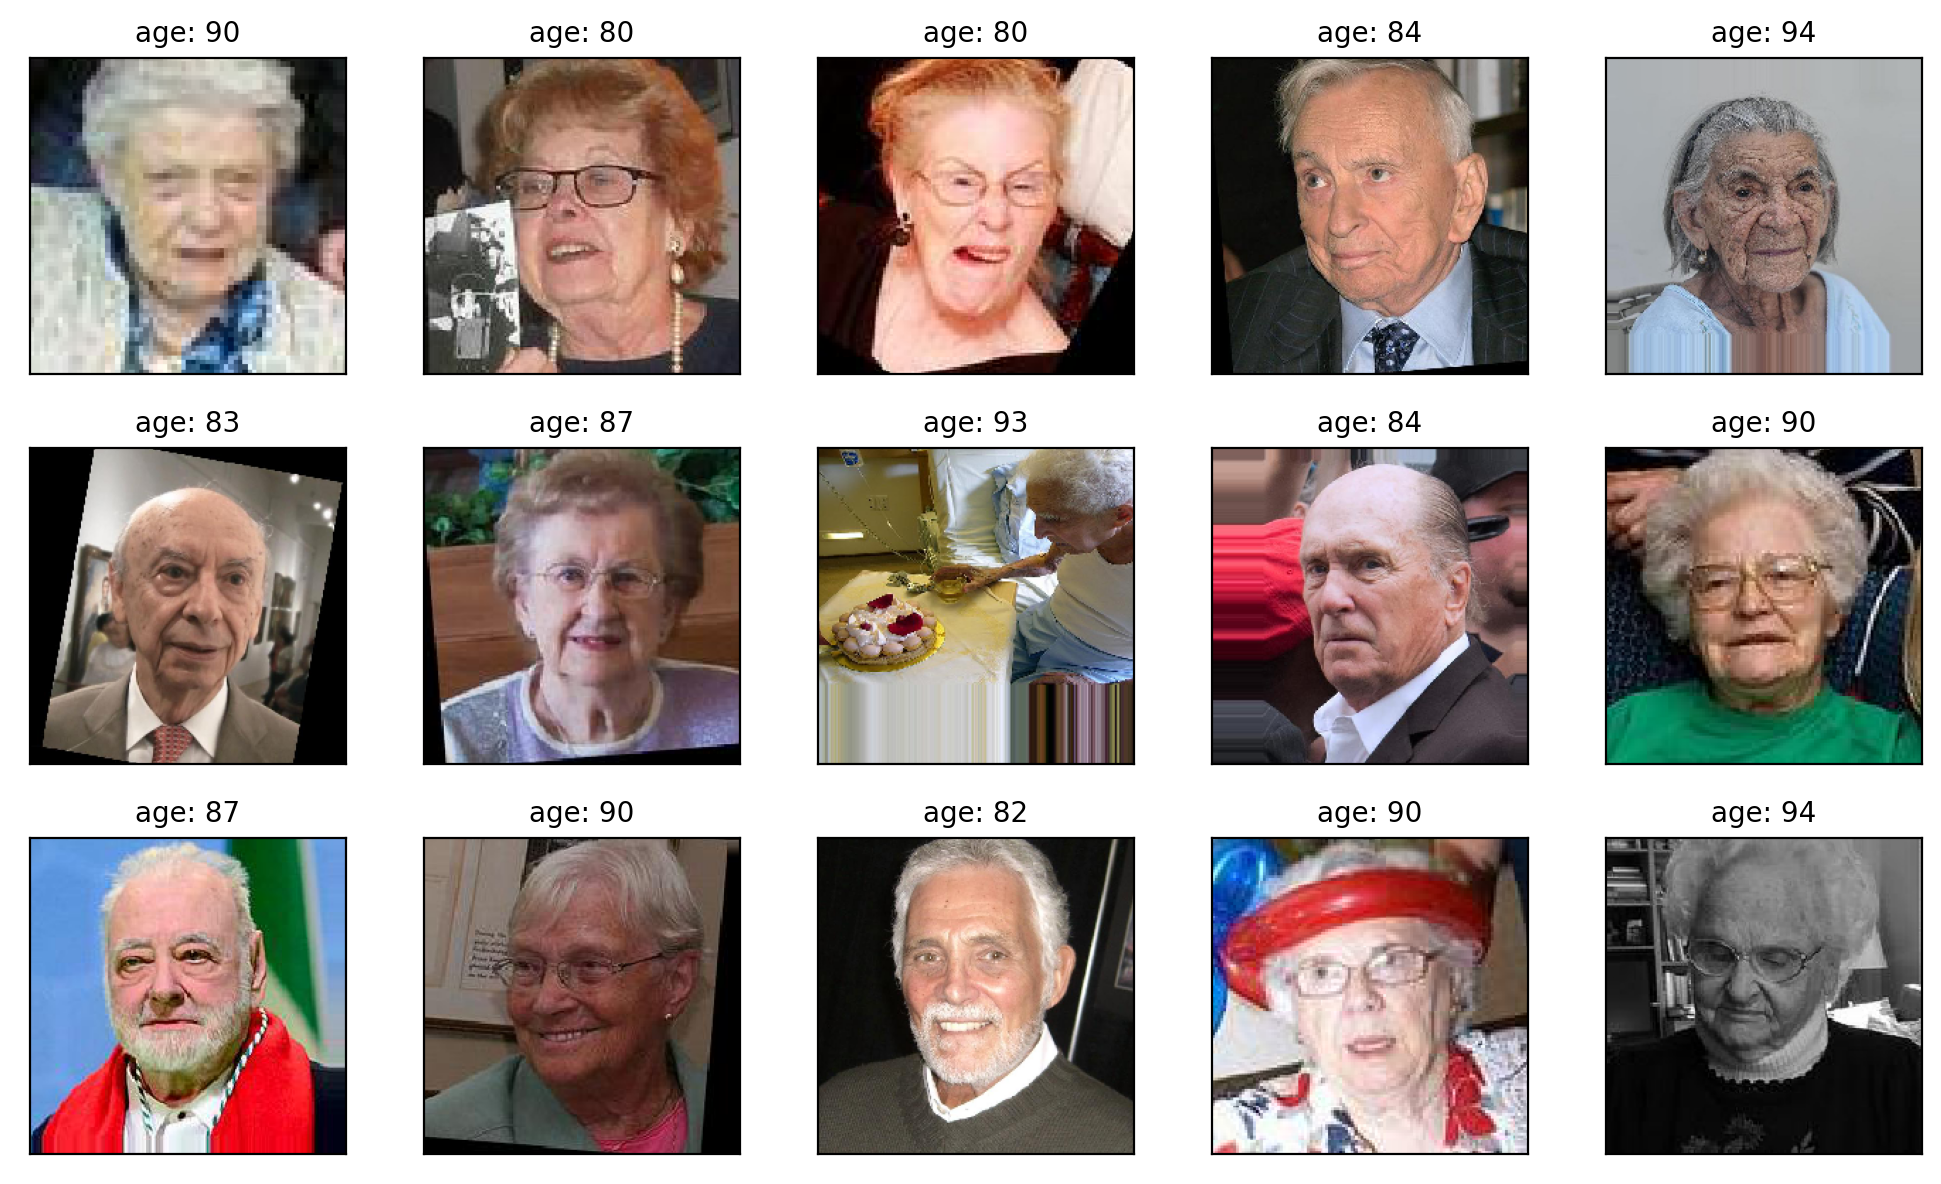

In [ ]:
show_batch(next(gen_flow_80_100))

### Findings

1. The size of the photo above is auto adjusted to 224x224, it needs to be done to use a trained model as it seen on ImageNet.
2. The image is already in the correct position.
3. The dataset has photos of different quality: there are old, black and white, and color images. It makes sense to augment using black and white photos with percentages in certain cases. Maybe we can add brightness augmentation, or use a color shade.
4. The faces in the dataset has different sizes: the pictures above require a zoom augmentation.
5. We have to use `horizontal_flip` and no need to use `vertical_flip`.

## 3. Data Modelling

Define the necessary functions to train your model on the GPU platform and create a single script that contains all of these functions with an initialization section.

To make it easier, you can define it in this *notebook* and run the ready-to-use code in the next section to build the scripts automatically.

In [ ]:
gpus = tf.config.list_physical_devices("GPU")

if gpus:

    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 1024 * 8)]
        )
    except RunTimeError as e:
        print(e)


logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

0 Physical GPUs, 0 Logical GPUs


In [ ]:
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='training',
            seed=12345)

    return train_gen_flow

In [ ]:
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=path + 'final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=16,
            class_mode='raw',
            subset='validation',
            seed=12345)

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )

    return model


In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

# 4. Preparing scripts to run on GPU platforms

Once you have defined the required functions, you can create a script for the GPU platform, download it via the "File|Open..." menu, and upload it later to run on the GPU platform.

Note: Your script must also include an initialization section. An example is shown below.

In [ ]:
# prepare the script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

**Running on the local platform**

In [ ]:
train_data = load_train('/datasets/faces/')
test_data = load_test('/datasets/faces/')
model = create_model((224, 224, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [ ]:
model = train_model(model, train_data, test_data)

Epoch 1/20


### *Output*

**Continue to Step 2 . . .**

```
Good Seed - Analysis Model - Step 2.ipynb
```

## 5 Overall Conclusion

1. The model is well trained when performed using MSE as a loss function. The steps in Adam's algorithm must be slightly reduced for better convergence.

2. We don't need to freeze the layer, but we still have to do augmentation.

3. The model above has quite a lot of overfitting, because of its complexity, it can be assumed that it's normal. It still can be met the expected quality.

4. The quality of the validation is not very stable, but can slowly decrease. This may be due to the rather small and heterogeneous samples

5. It is very difficult to meet MAE close to zero. Of course, it is very difficult for someone to determine the age of many images, and maybe it is because we do not have enough information related to the photos, and below a certain threshold the expected quality is often can not be obtained.